In [1]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
#spin function
def spin_func(x,a):
    # x np.ndarray with shape (n,d)
    n = x.shape[0]
    d = x.shape[1]
    y = x[:,np.newaxis, :]* x[:,:, np.newaxis]
    y = y[:,:,:,np.newaxis]* x[:,np.newaxis, np.newaxis, :]
    z = y*a[np.newaxis,:,:,:]
    return 1/d*z.sum(axis = (1,2,3)).reshape((1,n))

def grad_spin_func(x,a):
    n = x.shape[0]
    d = x.shape[1]
    df = 1/d*np.array([((a[p,:,:]+a[:,p,:]+a[:,:,p])[np.newaxis, :,:]\
                *(x[:,np.newaxis,:]*x[:,:, np.newaxis])).sum(axis = (1,2)) for p in range(d)]).reshape(n,d)
    return df

def spin_func_slice(X,Y,a,d = 5):
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return spin_func(x, a)
vspin_func_slice = np.vectorize(spin_func_slice)
vspin_func_slice.excluded.add(2)

In [3]:
#Initialise params
d = 5
a = np.random.normal(np.zeros((d,d,d)), np.ones((d,d,d)))

([], [])

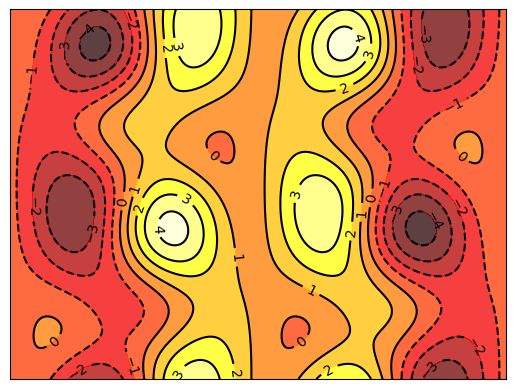

In [4]:
#contour plot of spin function
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vspin_func_slice(X, Y, a), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vspin_func_slice(X,Y, a), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])

In [5]:
def neural_net_symm(x, c, z):
    z = np.array(z)
    n = z.shape[0]
    d = z.shape[1]
    c = c.reshape(1,n)
    return 1/n*(np.exp(-x@z.T)@c.T).reshape(1,x.shape[0])

def neural_net_slice(X, Y, c, z, d = 5):
    print
    x = np.sqrt(d)*np.array([np.sin(X)*np.cos(Y), np.sin(X)*np.sin(Y), np.cos(X), 0, 0]).reshape(1,d)
    return neural_net_symm(x, c, z)
vneural_net_slice = np.vectorize(neural_net_slice)
vneural_net_slice.excluded.add(2)
vneural_net_slice.excluded.add(3)

In [7]:
def sample_uniform_sphere(r, d, n):
    s = np.random.multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    norm = np.sqrt(np.diag(s@s.T)).reshape(n,1)
    result = r*s/norm
    return result

In [296]:
#Training
def train(d = 5, n = 16, Dt = 1e3, steps = int(2*1e5)):
    #initialise parameters
    c = np.random.uniform(-40*d**2, 40*d**2, n).reshape(1,n)
    z = sample_uniform_sphere(np.sqrt(d), d, n).reshape(n,d)
    losses = np.zeros(steps)
    #update step
    for step in trange(steps):
        grad = grad_spin_func(z,a)
        exp = np.exp(-z@z.T)
        #sample points on sphere
        P = int(1e3)
        x = sample_uniform_sphere(np.sqrt(d), d, P).reshape(P,d)
        #exp_x = np.exp(-x@z.T)
        
        loss = 0.5*np.mean((spin_func(x,a)-neural_net_symm(x,c,z))**2)
        loss1 = -1/n*c@spin_func(z, a).T+0.5*1/n**2*c@exp@c.T
        
        #noise = white_noise(spin_func(z, a)-neural_net_symm(z,c,z), c1, z1, c2, z2)
        noise_c = np.sqrt(Dt/n)*np.random.multivariate_normal(np.zeros(n), np.diag(np.ones(n)), 1).reshape(1,n)
        noise_z = np.sqrt(Dt/n)*np.random.normal(np.zeros((n,d)), np.ones((n,d))).reshape(n,d)
        #neural_net_symm(z,c,z)
        
        c_next = c + (spin_func(z, a)-1/n*c@exp)*Dt  + noise_c
        z_next = z + (c.T*grad+1/n*(c.T*exp)@(c.T*z))*Dt + noise_z
        
        #c_next = c + (spin_func(x, a)@exp_x-1/n*c@exp_x.T@exp_x)*Dt/P
        #z_next = z - ((c.T*exp_x.T)@(spin_func(x, a).T*x)-1/n*(c.T*exp_x.T@((exp_x@c.T)*x)))*Dt/P
        
        #c_next = c + (spin_func(z, a)@exp-1/n*c@exp.T@exp)*Dt/n
        #z_next = z - ((c.T*exp.T)@(spin_func(z, a).T*z)-1/n*(c.T*exp.T@((exp@c.T)*z)))*Dt/n
        
        z_next = z_next*np.sqrt(d)/np.linalg.norm(z_next, axis = 1).reshape(n,1)
        losses[step] = loss1
        print('loss: {}'.format(loss1[0][0]))
        #print('c: {}'.format(c[0][0]))
        z = z_next
        c = c_next
        Dt = (1-0.1*np.floor(step/25000))*Dt
        
    return c,z, losses

In [349]:
c,z, losses = train(n = 16, steps = 2000, Dt = 1e-4)

  0%|          | 0/2000 [00:00<?, ?it/s]

loss: -532084.2388855956
loss: -2098279.733401173
loss: -3574863.2773906724
loss: -5445905.574348152
loss: -7537393.669426372
loss: -8014332.485106031
loss: -8121171.360902901
loss: -8228688.504393194
loss: -8337697.216006468
loss: -8448059.041446641
loss: -8559941.03083565
loss: -8673223.629477298
loss: -8788046.99969839
loss: -8904337.414819097
loss: -9022223.384486964
loss: -9141571.169252694
loss: -9262559.666467352
loss: -9385109.739237221
loss: -9509298.132449772
loss: -9635110.17413446
loss: -9762676.84243555
loss: -9891803.47902652
loss: -10022741.825355053
loss: -10155263.361575188
loss: -10289679.44066259
loss: -10425751.33074616
loss: -10563679.096086135
loss: -10703336.651607014
loss: -10844973.679545054
loss: -10988350.458261836
loss: -11133719.67338696
loss: -11280940.829594254
loss: -11430121.360895727
loss: -11581236.090886584
loss: -11734439.231519287
loss: -11889581.642242497
loss: -12046834.725631902
loss: -12206119.855667371
loss: -12367583.80987069
loss: -12531083.

loss: -562345059.5737557
loss: -569817108.8748732
loss: -577389040.8851979
loss: -585061590.6080166
loss: -592836787.5900244
loss: -600715161.6405219
loss: -608698384.8977166
loss: -616787216.1987891
loss: -624984483.015799
loss: -633290953.9555886
loss: -641708299.6442624
loss: -650236786.0415341
loss: -658879080.4177183
loss: -667636045.9394405
loss: -676510234.0458041
loss: -685502245.869606
loss: -694614473.6825274
loss: -703847282.8731339
loss: -713203679.6874017
loss: -722684115.8857777
loss: -732291454.4588094
loss: -742025794.2905241
loss: -751890528.7999693
loss: -761886048.428146
loss: -772015316.8030686
loss: -782279004.7218126
loss: -792679731.2461104
loss: -803218160.4020811
loss: -813897615.5214872
loss: -824718819.9506903
loss: -835684693.8145944
loss: -846796439.9596044
loss: -858056350.2251834
loss: -869465508.9037899
loss: -881026975.6588644
loss: -892742349.1497569
loss: -904614140.759971
loss: -916643561.452626
loss: -928834039.2738656
loss: -941186065.8370132
loss:

loss: -65422060233.042984
loss: -66297811138.634735
loss: -67185293278.12672
loss: -68084682202.97356
loss: -68996125287.53357
loss: -69919788179.79607
loss: -70855833971.567
loss: -71804436410.88637
loss: -72765750544.40532
loss: -73739960039.7456
loss: -74727225810.61974
loss: -75727737234.85939
loss: -76741651532.403
loss: -77769173318.61748
loss: -78810468580.59456
loss: -79865729209.86264
loss: -80935131788.4216
loss: -82018884416.79187
loss: -83117164435.69586
loss: -84230177330.6135
loss: -85358112469.48663
loss: -86501183684.43651
loss: -87659574237.07915
loss: -88833506688.52159
loss: -90023172456.27887
loss: -91228811165.62302
loss: -92450612004.32655
loss: -93688806909.48622
loss: -94943600719.83908
loss: -96215232249.43521
loss: -97503914437.07068
loss: -98809891240.76283
loss: -100133377435.85455
loss: -101474623930.44316
loss: -102833856711.82466
loss: -104211327567.30405
loss: -105607267801.74422
loss: -107021945614.26466
loss: -108455593029.43436
loss: -109908483573.886

loss: -7263784711052.022
loss: -7361673616886.62
loss: -7460883587079.871
loss: -7561432362675.963
loss: -7663338130846.123
loss: -7766619117339.829
loss: -7871294002319.39
loss: -7977381539601.482
loss: -8084900931173.163
loss: -8193871396568.039
loss: -8304312655348.798
loss: -8416244496057.16
loss: -8529687156551.137
loss: -8644660952233.811
loss: -8761186725030.255
loss: -8879285318530.38
loss: -8998978105535.238
loss: -9120286494365.238
loss: -9243232417021.928
loss: -9367837927938.377
loss: -9494125563509.324
loss: -9622117966804.121
loss: -9751838335646.977
loss: -9883309804553.031
loss: -10016556245831.756
loss: -10151601511608.377
loss: -10288470040803.195
loss: -10427186311205.668
loss: -10567775459015.826
loss: -10710262766172.24
loss: -10854673930016.604
loss: -11001034817774.242
loss: -11149371995251.809
loss: -11299712025206.828
loss: -11452082068205.451
loss: -11606509447959.16
loss: -11763022136794.682
loss: -11921648249715.082
loss: -12082416450795.484
loss: -122453555

loss: -697824241985748.1
loss: -707284962997303.4
loss: -716874110856076.9
loss: -726593430147829.1
loss: -736444691916973.1
loss: -746429687475233.2
loss: -756550236129853.9
loss: -766808179291721.4
loss: -777205385683152.8
loss: -787743746912155.1
loss: -798425183158282.8
loss: -809251638147749.2
loss: -820225084405283.6
loss: -831347518274559.6
loss: -842620967458640.2
loss: -854047482793719.5
loss: -865629146804067.9
loss: -877368067719995.0
loss: -889266384369943.1
loss: -901326262277115.8
loss: -913549899342549.1
loss: -925939521196547.4
loss: -938497385367034.6
loss: -951225778105373.5
loss: -964127019017511.0
loss: -977203456842004.4
loss: -990457475303934.1
loss: -1003891487774258.1
loss: -1017507943029915.1
loss: -1031309320317663.0
loss: -1045298135681326.0
loss: -1059476936309172.9
loss: -1073848306789402.0
loss: -1088414865149650.2
loss: -1103179266973987.6
loss: -1118144200244459.0
loss: -1133312394413961.2
loss: -1148686611986004.5
loss: -1164269655805919.2
loss: -118006

loss: -9.526570896679771e+16
loss: -9.656499703826912e+16
loss: -9.788202630889312e+16
loss: -9.921703929552333e+16
loss: -1.0057028185260243e+17
loss: -1.0194200318834128e+17
loss: -1.0333245592668005e+17
loss: -1.0474189613604728e+17
loss: -1.0617058341567498e+17
loss: -1.0761878088747376e+17
loss: -1.090867553020818e+17
loss: -1.1057477703440989e+17
loss: -1.1208312018813933e+17
loss: -1.1361206259583272e+17
loss: -1.1516188590485931e+17
loss: -1.1673287560800378e+17
loss: -1.1832532112545843e+17
loss: -1.1993951581520402e+17
loss: -1.2157575706796619e+17
loss: -1.2323434633628466e+17
loss: -1.2491558920877243e+17
loss: -1.2661979544115429e+17
loss: -1.2834727905314032e+17
loss: -1.3009835833516146e+17
loss: -1.3187335595913994e+17
loss: -1.3367259899600498e+17
loss: -1.3549641900906622e+17
loss: -1.3734515209208429e+17
loss: -1.3921913895019629e+17
loss: -1.4111872493108398e+17
loss: -1.4304426014377507e+17
loss: -1.449960994503948e+17
loss: -1.4697460260785674e+17
loss: -1.4898013

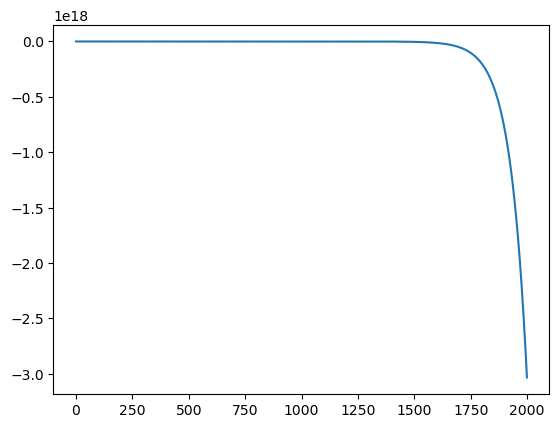

In [350]:
plt.plot(losses)

([], [])

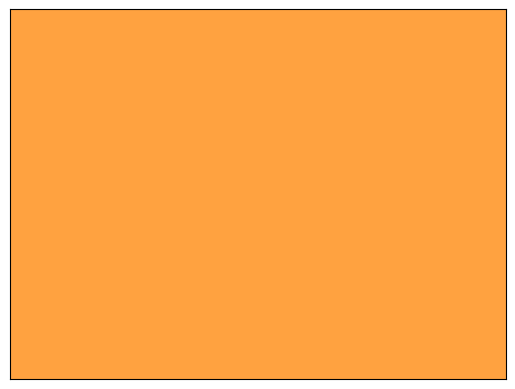

In [340]:
#contour plot of neural net reconstruction
n = 256
x = np.linspace(-np.pi, np.pi, n)
y = np.linspace(0, 2*np.pi, n)
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, vneural_net_slice(X, Y, c,z), 8, alpha=.75, cmap=plt.cm.hot)
C = plt.contour(X, Y, vneural_net_slice(X,Y, c,z), 8, colors='black')
plt.clabel(C, inline=1, fontsize=10)
plt.xticks([])
plt.yticks([])